In [26]:
import os
import argparse
import importlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import transforms
import numpy as np

In [3]:
import mnist; importlib.reload(mnist)

<module 'mnist' from '/home/hminle/Github/weekly-ml-projects/conditional-vae/mnist.py'>

In [4]:
# Define parser arguments
parser = {
    "batch_size": 128,
    "epochs": 10,
    "no_cuda": False,
    "seed": 1,
    "log_interval": 10,
}

In [5]:
# Parse arguments for  model
args = argparse.Namespace(**parser) # parse arguments
args.cuda = not args.no_cuda and torch.cuda.is_available()

## Load data

In [6]:
train_loader = torch.utils.data.DataLoader(
    mnist.MNIST('../data', train=True, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    mnist.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=args.batch_size, shuffle=True)

## Define parameters

In [7]:
mb_size = args.batch_size
Z_dim = 100
#X_dim = mnist.train.images.shape[1]
#y_dim = mnist.train.labels.shape[1]
X_dim = 784
y_dim = 10
h_dim = 128
cnt = 0
lr = 1e-3

In [8]:
# Init weights
# size[0]: input dim
# size[1]: output dim
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)

## Encode

In [9]:
Wxh = xavier_init(size=[X_dim + y_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Whz_mu = xavier_init(size=[h_dim, Z_dim])
bhz_mu = Variable(torch.zeros(Z_dim), requires_grad=True)

Whz_var = xavier_init(size=[h_dim, Z_dim])
bhz_var = Variable(torch.zeros(Z_dim), requires_grad=True)

In [10]:
# mu and var --> encoder --> need them for reparemetric --> z
def Q(X, c):
    inputs = torch.cat([X, c], 1) #concat: batch_sizex(X:784 + y: 10) = batch_size x 794
    h = F.relu(inputs @ Wxh + bxh.repeat(inputs.size(0), 1)) #bxh = 64 x h_dim
    z_mu = h @ Whz_mu + bhz_mu.repeat(h.size(0), 1)
    z_logvar = h @ Whz_var + bhz_var.repeat(h.size(0), 1)
    return z_mu, z_logvar

In [24]:
def sample_z(mu, log_var):
    eps = Variable(torch.randn(mu.size(0), Z_dim)) # eps--> random normal distribution
    return mu + torch.exp(log_var / 2) * eps # --> z = mu + std_var*eps

## Decode


In [12]:
# =============================== P(X|z) ======================================

Wzh = xavier_init(size=[Z_dim + y_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def P(z, c):
    inputs = torch.cat([z, c], 1)
    h = F.relu(inputs @ Wzh + bzh.repeat(inputs.size(0), 1))
    X = F.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X

## Training

In [13]:
params = [Wxh, bxh, Whz_mu, bhz_mu, Whz_var, bhz_var,
          Wzh, bzh, Whx, bhx]

# Define optimizer: similar to optim.Adam(model.parameters, lr=lr)
solver = optim.Adam(params, lr=lr) 

In [21]:
# label: torch.LongTensor
def oneHot(label):
    arrayTmp = np.zeros(shape=[label.size(0), y_dim])
    for rowIndex, value in enumerate(label):
        arrayTmp[rowIndex][value] = 1
    return torch.from_numpy(arrayTmp.astype('float32'))

In [22]:
label = None
for X, c in train_loader:
    print(X.view(-1, 784).size())
    print(oneHot(c).size())
    torch.cat([X.view(-1, 784), oneHot(c)], 1)
    label = c
    break

torch.Size([128, 784])
torch.Size([128, 10])


In [16]:
label


 7
 5
 4
 4
 9
 1
 3
 5
 1
 4
 8
 5
 5
 2
 9
 2
 4
 7
 2
 7
 8
 9
 8
 3
 2
 3
 7
 0
 2
 6
 6
 4
 7
 3
 3
 2
 9
 2
 5
 2
 3
 8
 8
 6
 4
 5
 2
 3
 3
 2
 0
 2
 5
 3
 8
 4
 5
 3
 9
 2
 8
 0
 5
 7
 7
 3
 4
 1
 4
 6
 9
 5
 3
 3
 9
 9
 8
 6
 7
 2
 6
 1
 0
 8
 9
 0
 1
 8
 3
 3
 0
 6
 2
 6
 8
 9
 8
 2
 6
 6
 9
 2
 0
 5
 6
 2
 0
 0
 4
 5
 4
 2
 6
 3
 2
 9
 2
 8
 1
 8
 0
 8
 1
 4
 9
 1
 8
 7
[torch.LongTensor of size 128]

In [17]:
a = np.zeros(shape=[2,3])
a[0][1]=1
a

array([[ 0.,  1.,  0.],
       [ 0.,  0.,  0.]])

In [18]:
oneHot(label)


    0     0     0  ...      1     0     0
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     0
       ...          ⋱          ...       
    0     1     0  ...      0     0     0
    0     0     0  ...      0     1     0
    0     0     0  ...      1     0     0
[torch.FloatTensor of size 128x10]

Iter-0; Loss: 0.23


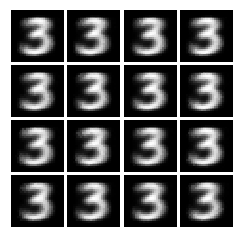

In [29]:
#for it in range(100000):
for it, (X, c) in enumerate(train_loader):
    X = X.view(-1, 784)
    X = Variable(X)
    c = Variable(oneHot(c))

    # Forward
    z_mu, z_logvar = Q(X, c)
    z = sample_z(z_mu, z_logvar)
    X_sample = P(z, c)

    # Loss
    recon_loss = F.binary_cross_entropy(X_sample, X, size_average=True)
    kl_loss = torch.mean(0.5 * torch.sum(torch.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1))
    loss = recon_loss + kl_loss

    # Housekeeping
    for p in params:
        p.grad.data.zero_()
        
    # Backward
    loss.backward()

    # Update
    solver.step()


    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; Loss: {:.4}'.format(it, loss.data[0]))

        c = np.zeros(shape=[mb_size, y_dim], dtype='float32')
        c[:, np.random.randint(0, 10)] = 1.
        c = Variable(torch.from_numpy(c))
        z = Variable(torch.randn(mb_size, Z_dim))
        samples = P(z, c).data.numpy()[:16]

        fig = plt.figure(figsize=(4, 4))
        gs = gridspec.GridSpec(4, 4)
        gs.update(wspace=0.05, hspace=0.05)

        for i, sample in enumerate(samples):
            ax = plt.subplot(gs[i])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

        #if not os.path.exists('out/'):
        #    os.makedirs('out/')

        #plt.savefig('out/{}.png'.format(str(cnt).zfill(3)), bbox_inches='tight')
        plt.show()
        cnt += 1
        plt.close(fig)